# Posterior given observation ranges

This tutorial builds on [https://github.com/mackelab/sbi/blob/main/examples/00_HH_simulator.ipynb]. 

We will estimate the posterior given an obersavtion range and apply this on a [Hodgkin-Huxley model](https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model) from neuroscience (Hodgkin and Huxley, 1952). The model is parametrized by the sodium and potassium conductance ($\bar g_{Na}$,$\bar g_K$). The goal is to learn the model parameters from current-clamp recordings, that we generate synthetically (in practice, this would be an experimental observation).

First import basic packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch.utils import data
import pandas as pd
import seaborn as sns
from functools import partial

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
from sbi import utils as utils
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.neural_nets.flow import build_uncond_maf, build_maf, build_nsf, build_made
from sbi.analysis import pairplot

from examples.HH_helper_functions import syn_current, HHsimulator, calculate_summary_statistics

In [3]:
# remove top and right axis from plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

## Different required components

Before running inference, let us define the different required components:

1. observed data
1. prior over model parameters
2. simulator

## 1. Oberserved Data

For this tutorial we will use synthetically generated data by simulating a Hodgkin-Huxley model with particular parameters ($\bar g_{Na}$,$\bar g_K$). 

## 2. Simulator

Define input current as

In [4]:
I, t_on, t_off, dt, t, A_soma = syn_current()

Putting the input current and the HHsimulator together:

In [5]:
def run_HH_model(params):

    params = np.asarray(params)
    
    # input current, time step
    I, t_on, t_off, dt, t, A_soma = syn_current()

    t = np.arange(0, len(I), 1)*dt

    # initial voltage
    V0 = -70
    
    states = HHsimulator(V0, params.reshape(1, -1), dt, t, I)

    return dict(data=states.reshape(-1), time=t, dt=dt, I=I.reshape(-1))

### Sample traces
To get an idea of the output of the Hodgkin-Huxley model, let us generate some voltage traces for different parameters ($\bar g_{Na}$,$\bar g_K$), given the input current $I_{\text{inj}}$:

In [6]:
def generate_traces(params, title=None, file=None):
    num_samples = len(params[:,0])
    sim_samples = np.zeros((num_samples, len(I)))
    sim_spikes = np.zeros(num_samples)
    for i in range(num_samples):
        sim = run_HH_model(params=params[i,:])#['data']
        sim_samples[i,:] = sim['data']
        sim_spikes[i] = calculate_summary_statistics(sim)[0]
    #visualize
    # colors for traces
    col_min = 2
    num_colors = num_samples+col_min
    cm1 = mpl.cm.Blues
    col1 = [cm1(1.*i/num_colors) for i in range(col_min,num_colors)]

    fig = plt.figure(figsize=(7,5))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    ax = plt.subplot(gs[0])
    plt.axhline(-10, color="r", alpha=0.5) #cut-off for spikes
    for i in range(num_samples):
        plt.plot(t,sim_samples[i,:],color=col1[i],lw=2)
    plt.ylabel('voltage (mV)')
    ax.set_xticks([])
    ax.set_yticks([-80, -20, 40])
    if title is not None: 
        plt.title(title)

    ax = plt.subplot(gs[1])
    plt.plot(t,I*A_soma*1e3,'k', lw=2)
    plt.xlabel('time (ms)')
    plt.ylabel('input (nA)')

    ax.set_xticks([0, max(t)/2, max(t)])
    ax.set_yticks([0, 1.1*np.max(I*A_soma*1e3)])
    ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))

    if file is not None:
        plt.tight_layout()
        plt.savefig('../sbi/figures/' + file+'.pdf')

    plt.show()
    return sim_spikes

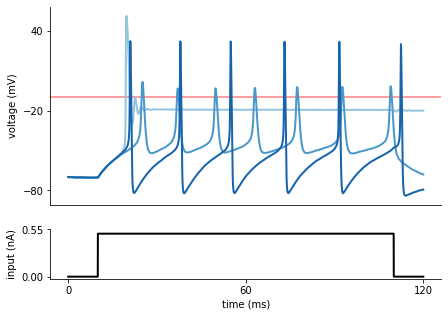

In [7]:
# three sets of (g_Na, g_K)
params = np.array([[50., 1.],[4., 1.5],[20., 15.]])
_ = generate_traces(params)

As can be seen, the voltage traces can be quite diverse for different parameter values.

### Summary Statistics
Often, we are not interested in matching the exact trace, but only in matching certain features thereof. In this example of the Hodgkin-Huxley model, the summary features are:
- the number of spikes, 
- the mean resting potential, 
- the standard deviation of the resting potential, and 
- the first four voltage moments: mean, standard deviation, skewness and kurtosis. 

Using the function `calculate_summary_statistics()`, we obtain these statistics from the output of the Hodgkin Huxley simulator. 

In [8]:
def HHsimulation_wrapper(params):
    """
    Returns summary statistics from conductance values in `params`.
    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    obs = run_HH_model(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))
    return summstats

def HHsimulation_masked(params, mask=torch.ones(7)):
    """
    Returns selected summary statistics from conductance values in `params`.
    Use mask to indicate which summary statistics to select. 
    For partial evaluation: partial(HHsimulation_masked, mask=...)
    """
    return HHsimulation_wrapper(params)[mask]


## 3. Prior over model parameters

Now that we have the simulator, we need to define a function with the prior over the model parameters ($\bar g_{Na}$,$\bar g_K$), which in this case is chosen to be a Uniform distribution:

In [9]:
prior_min = [.5,1e-4]
prior_max = [80.,15.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

## Inference
Now that we have all the required components, we can run inference with SNPE to identify parameters whose activity matches this trace.

In [10]:
# use spike count only
#mask_sc = torch.tensor([True, False, False, False, False, False, False]) 

In [10]:
def inference(simulation, prior, mask=torch.ones(7).bool(), num_sim=1000, load=False, num_workers=4):
    simulator, prior = prepare_for_sbi(partial(simulation, mask=mask), prior)
    inference = SNPE(prior=prior)
    if not load: 
        print("Simulate.", end= "\r")
        sim_thetas, sim_xs = simulate_for_sbi(simulator, proposal=prior, num_simulations=num_sim, num_workers=num_workers)
    else:
        print("Load simulations.", end= "\r")
        # load from simulator with full summary statistics
        sim_xs = torch.load("notebooks/samples/HH_sample_obs_50k.pt")[:, mask]
        sim_thetas = torch.load("notebooks/samples/HH_sample_theta_50k.pt")

    print("Build posterior.", end= "\r")
    inference = inference.append_simulations(sim_thetas, sim_xs)
    density_estimator = inference.train()
    posterior_sbi = inference.build_posterior(density_estimator)

    return sim_xs, sim_thetas, posterior_sbi


#### Utils

In [11]:
def get_mask(x_range):
    if x_range.type() != "torch.FloatTensor":
            x_range = x_range.float()
    mask = torch.logical_not(
            torch.logical_and(
                x_range[0, :] == float("-inf"),
                x_range[1, :] == float("inf")
            ))
    return mask 


def hist_spikes(obs):
    plt.figure(figsize=(4,3))
    plt.hist(obs[:,0].numpy(), bins=np.arange(max(obs[:,0])+2)-0.5, ec="k", density=True)
    plt.xticks(np.arange(max(obs[:,0])+1))
    plt.title("Spike counts of accepted observations")
    plt.show()

def overview_stats(data, mask=torch.ones(7).bool()):
    return pd.DataFrame(data= torch.vstack([data.mean(dim=0), 
                                            data.std(dim=0), 
                                            data.min(dim=0).values, 
                                            data.max(dim=0).values]).numpy(), 
                        index = ['mean', 'std' , 'min', 'max'], 
                        columns=[i for (i, select) in zip(['spike_count', 'mean_rp','std_rp', 'mean', 'std', 'skewness', 'kurtosis'], mask) if select]
                        )

### Posterior using all summary statistics 

In [19]:
sim_xs_full, sim_thetas_full, posterior_full = inference(HHsimulation_masked, prior, num_sim=300)
#torch.save(sim_xs_full, "notebooks/samples/HH_sample_obs_50k.pt")
#torch.save(sim_thetas_full, "notebooks/samples/HH_sample_theta_50k.pt")
sim_xs_full.shape

Running 300 simulations in 300 batches.: 100%|██████████| 300/300 [03:07<00:00,  1.60it/s]


Neural network successfully converged after 318 epochs.


torch.Size([300, 7])

Inspect simulated observations

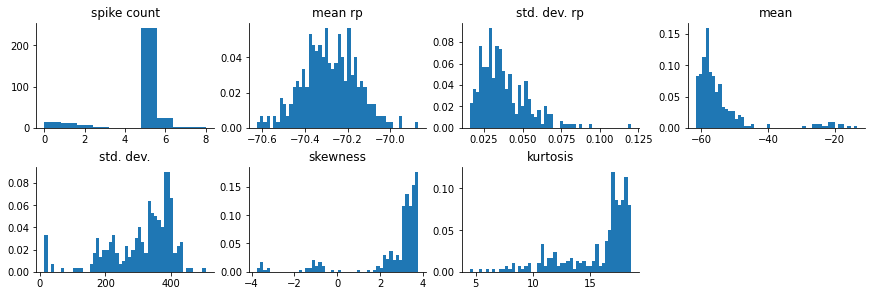

In [20]:
fig, axs = plt.subplots(2, 4, figsize=(12, 4), constrained_layout=True)
names = ['spike count', 'mean rp', 'std. dev. rp', 'mean', 'std. dev.', 'skewness', 'kurtosis']
for i in range(sim_xs_full.shape[1]):
    if i==0:
        axs[i//4,i%4].hist(sim_xs_full[:,i].numpy())
    else:
        axs[i//4,i%4].hist(sim_xs_full[:,i].numpy(), weights=np.zeros_like(sim_xs_full[:,0]) + 1. / sim_xs_full[:,0].shape[0], bins=50)
    axs[i//4,i%4].set_title(names[i])
axs[-1, -1].axis('off')
plt.show()

In [21]:
overview_stats(sim_xs_full)

,spike_count,mean_rp,std_rp,mean,std,skewness,kurtosis
mean,4.656667,-70.285843,0.037860,-54.040115,311.893860,2.667348,15.662888
std,1.372979,0.127175,0.015344,9.717360,98.454613,1.680470,3.032401
min,0.000000,-70.623299,0.015571,-61.650604,13.523958,-3.745061,4.471957
max,8.000000,-69.870056,0.120206,-13.331629,505.964172,3.775627,18.532328


### Posterior Given Range of Spike Count (Unconditional Flow)

Specify a range on all dimensions.
When only specifying a range on a subset of dimensions (setting other dimensions to [-inf, inf]), the others will be ignored using a mask as they would be integrated out. Be aware that the posterior is then only specified for the unmasked dimensions, throwing away the others. 

Might require learning a posterior for the subset of dimensions.

In [73]:
x_range1 = torch.tensor([[0., -np.infty, -np.infty, -np.infty, -np.infty, -np.infty, -np.infty],[3.0, np.infty, np.infty, np.infty, np.infty, np.infty, np.infty]])
mask1 = get_mask(x_range1)

In [74]:
range_xs = sim_xs_full[:,mask1]
point_xs = sim_xs_full[:,~mask1]

In [78]:
# learn posterior over unmasked dimensions
sim_xs1, sim_thetas1, posterior1 = inference(HHsimulation_masked, prior, mask1,num_sim=300)

Running 300 simulations in 300 batches.: 100%|██████████| 300/300 [04:24<00:00,  1.13it/s]


Neural network successfully converged after 132 epochs.


In [82]:
xs_acc_uncond, post_samples_uncond = posterior1.sample_range(x_range1[:,mask1], sim_xs1, (300,))

37 accepted observations x_i, sampling 9 from each individual posterior p(theta|x_i).


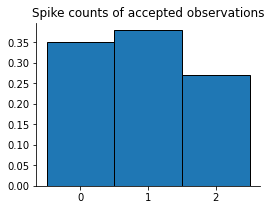

In [85]:
hist_spikes(xs_acc_uncond)

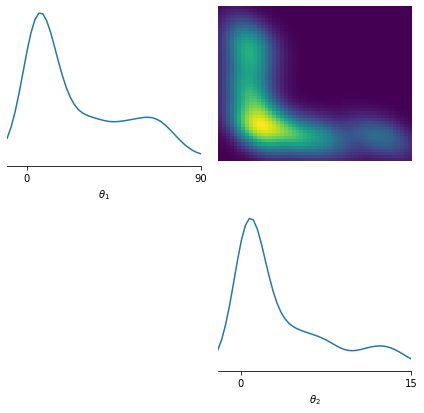

In [83]:
fig, _ = pairplot(post_samples_uncond, 
                 figsize=(6,6), 
                 limits=[[-10,90], [-2,15]],
                 ticks=[[0, 90], [0, 15.]], 
                 upper='kde', diag='kde', 
                 labels=[r'$\theta_1$', r'$\theta_2$'])
fig.tight_layout()

### Posterior Given Range of Spike Count (Conditional Flow)

Instead of providing a range on all dimensions of the observations, it is often of interest to specify ranges for only a subset of dimensions while keeping others fixed. To do so, we implemented a conditional flow as density estimator.

Let x be an observation, denote as x_range the subset of dimensions for which a observation range is specified and as x_point the dimensions for which a single value is given. Then we can express $p(x) = p(x_{range}|x_{point})p(x_{point})$ and train a conditional flow to estimate $p(x_{range}|x_{point})$.

In [96]:
x_range1 = torch.tensor([[0., -np.infty, -70, -np.infty, -np.infty, -np.infty, -np.infty],[3.0, np.infty, np.infty, -30, np.infty, np.infty, np.infty]])
mask1 = get_mask(x_range1)

In [97]:
# get some sample context
range_xs = sim_xs_full[:,mask1]
point_xs = sim_xs_full[:,~mask1]

points_xs_inrange = point_xs[torch.all(sim_xs_full[:,mask1] >= x_range1[:,mask1][0, :], dim=1) & torch.all(sim_xs_full[:,mask1] <= x_range1[:,mask1][1, :], dim=1)]
c = points_xs_inrange[:1]

In [98]:
x_acc, post_samples = posterior_full.sample_range(x_range1, sim_xs_full, (300,), c, train_px=True)

Context provided, use conditional NSF.
Converged after 44 epochs.:         0.101, best val_log_prob:             1.614
310 accepted observations x_i, sampling 1 from each individual posterior p(theta|x_i).


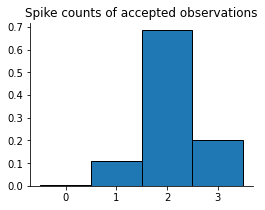

In [99]:
hist_spikes(x_acc)

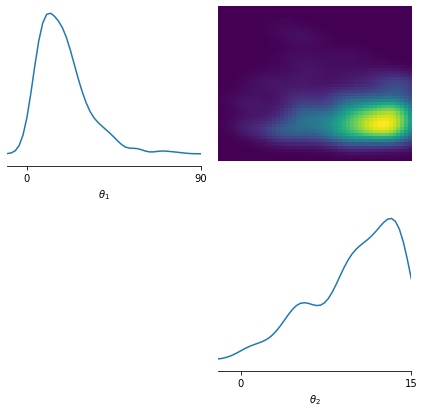

In [100]:
fig, _ = pairplot(post_samples, 
                 figsize=(6,6), 
                 limits=[[-10,90], [-2,15]],
                 ticks=[[0, 90], [0, 15.]], 
                 upper='kde', diag='kde', 
                 labels=[r'$\theta_1$', r'$\theta_2$'])
fig.tight_layout()

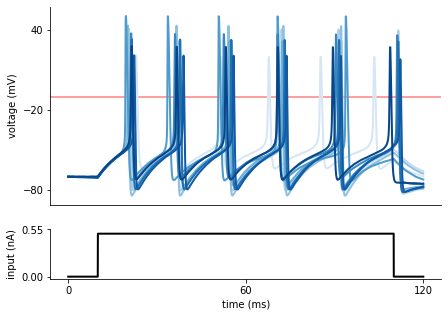

array([6., 5., 5., 5., 5., 5., 5., 5., 5., 6.])

In [101]:
generate_traces(post_samples[:10])

### Posterior Predictives

In [102]:
from tqdm.auto import tqdm

In [103]:
pbar = tqdm(total=post_samples.shape[0])
with pbar: 
    sum_stats = []
    for params in post_samples:
        sum_stats.append(HHsimulation_wrapper(params))
        pbar.update(1)
sum_stats= torch.stack(sum_stats)

100%|██████████| 310/310 [10:31<00:00,  2.04s/it]


In [104]:
x_range1

tensor([[  0., -inf, -70., -inf, -inf, -inf, -inf],
        [  3.,  inf,  inf, -30.,  inf,  inf,  inf]])

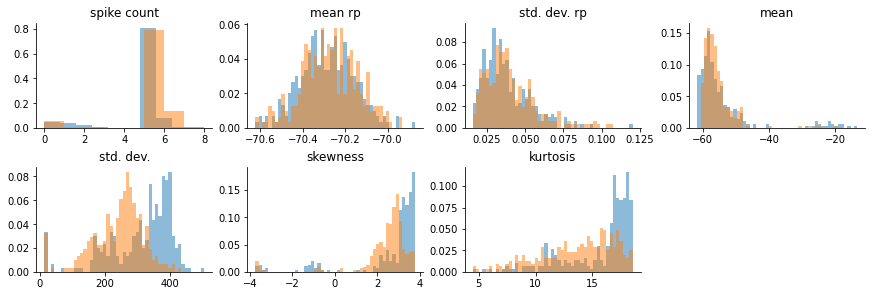

In [105]:
fig, axs = plt.subplots(2, 4, figsize=(12, 4), constrained_layout=True)
names = ['spike count', 'mean rp', 'std. dev. rp', 'mean', 'std. dev.', 'skewness', 'kurtosis']
for i in range(sum_stats.shape[1]):
    if i==0:
        bins = np.arange(sim_xs_full[:,i].min().item(), sim_xs_full[:,i].max().item())
        # plot simulations
        axs[i//4,i%4].hist(sim_xs_full[:,i].numpy(), weights=np.zeros_like(sim_xs_full[:,0]) +1./sim_xs_full.shape[0], alpha=0.5)
        # plot simulations with parameters from posterior
        axs[i//4,i%4].hist(sum_stats[:,i].numpy(), bins=bins, weights=np.zeros_like(sum_stats[:,0]) +1./sum_stats.shape[0], alpha=0.5)
    else:
        bins = np.linspace(sim_xs_full[:,i].min().item(), sim_xs_full[:,i].max().item(), 50)
        # plot simulations
        axs[i//4,i%4].hist(sim_xs_full[:,i].numpy(), weights=np.zeros_like(sim_xs_full[:,0]) + 1. / sim_xs_full[:,0].shape[0], bins=bins, alpha=0.5)
        # plot simulations with parameters from posterior
        axs[i//4,i%4].hist(sum_stats[:,i].numpy(), weights=np.zeros_like(sum_stats[:,0]) + 1. / sum_stats.shape[0], bins=bins, alpha=0.5)
    axs[i//4,i%4].set_title(names[i])
axs[-1, -1].axis('off')
plt.show()